In [1]:
# Include so results on different machines are (should be) the same.
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
!jupyter nbconvert --to script Keras_BagnallCharacter_SimpleRNN.ipynb

[NbConvertApp] Converting notebook Keras_BagnallCharacter_SimpleRNN.ipynb to script
[NbConvertApp] Writing 13366 bytes to Keras_BagnallCharacter_SimpleRNN.py


In [4]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
loaded_labels = []
loaded_text = []
presidents = [
    "Barack Obama",
    "Donald J. Trump",
    "Dwight D. Eisenhower",
    "Franklin D. Roosevelt",
    "George Bush",
    "George W. Bush",
    "Gerald R. Ford",
    "Harry S. Truman",
    "Herbert Hoover",
    "Jimmy Carter",
    "John F. Kennedy",
    "Lyndon B. Johnson",
    "Richard Nixon",
    "Ronald Reagan",
    "William J. Clinton"
]

labels = {}
for idx, name in enumerate(presidents):
    labels[name] = idx

# load raw text files straight in, no parsing
file_to_label = {
    "Obama": "Barack Obama",
    "Trump": "Donald J. Trump",
    "Eisenhower": "Dwight D. Eisenhower",
    "Roosevelt": "Franklin D. Roosevelt",
    "Bush": "George Bush",
    "WBush": "George W. Bush",
    "Ford": "Gerald R. Ford",
    "Truman": "Harry S. Truman",
    "Hoover": "Herbert Hoover",
    "Carter": "Jimmy Carter",
    "Kennedy": "John F. Kennedy",
    "Johnson": "Lyndon B. Johnson",
    "Nixon": "Richard Nixon",
    "Reagan": "Ronald Reagan",
    "Clinton": "William J. Clinton"
}

directory = "../data/processed/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 


print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."
# processed2 now contains files generated from unprocessed
directory = "../data/processed3/"
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    if any(prefix in arr[0] for prefix in file_to_label.keys()):
        loaded_labels = loaded_labels + [labels[file_to_label[arr[0]]]]
        raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
        loaded_text = loaded_text + [raw] 

print "Loaded", len(loaded_text), "speeches for", len(set(loaded_labels)), "presidents."

Loaded 30 speeches for 2 presidents.
Loaded 1747 speeches for 15 presidents.


In [5]:
#
# Bagnall 2015 text pre-processing
#
from string import maketrans
import re

chars_to_replace = "[]%!()>=*&_}+"
sub_chars = len(chars_to_replace) * " "
trantab = maketrans(chars_to_replace, sub_chars)
for x in range(0,len(loaded_text)):
    # "Various rare characters that seemed largely equivalent are mapped together..."
    loaded_text[x] = re.sub('`', '\'', loaded_text[x])
    loaded_text[x] = re.sub('--', '-', loaded_text[x])
    loaded_text[x] = re.sub('\n\n', '\n', loaded_text[x])
    # "...all digits in all languages are mapped to 7"
    loaded_text[x] = re.sub('[0-9]+', '7', loaded_text[x])
    # "...any character with a frequency lower than 1 in 10,000 is discarded."
    loaded_text[x] = loaded_text[x].translate(trantab)
    # "Runs of whitespace are collapsed into a single space."
    loaded_text[x] = re.sub(' +', ' ', loaded_text[x])

print "Replacements complete."

Replacements complete.


In [6]:
#
# Join all speeches into one massive per president
#  for later processing
#
import numpy as np
from scipy import stats
from operator import itemgetter
from collections import defaultdict

compressed_text = [None]*(len(labels))
for key, value in sorted(labels.iteritems()):
    compressed_text[value] = ""
    for idx in range(0,len(loaded_text)):
        if (loaded_labels[idx] == value):
            compressed_text[value] = compressed_text[value] + loaded_text[idx] + " "
            
print "How many characters of text per president?"
for key, value in sorted(labels.iteritems()):
    print str(value).ljust(2), ":", key.ljust(20), "\t", len(compressed_text[value])

label_min_chars = len(min(compressed_text, key=len))
print "\nMinimum number of characters per president?"
print label_min_chars

How many characters of text per president?
0  : Barack Obama         	4864552
1  : Donald J. Trump      	554802
2  : Dwight D. Eisenhower 	3073305
3  : Franklin D. Roosevelt 	2119838
4  : George Bush          	1892831
5  : George W. Bush       	1765572
6  : Gerald R. Ford       	709031
7  : Harry S. Truman      	2025461
8  : Herbert Hoover       	774461
9  : Jimmy Carter         	1285515
10 : John F. Kennedy      	1341542
11 : Lyndon B. Johnson    	2324156
12 : Richard Nixon        	970918
13 : Ronald Reagan        	980653
14 : William J. Clinton   	1762370

Minimum number of characters per president?
554802


In [7]:
#
# Tokenize words into chars
#
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Tokenize into characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(compressed_text)
tokenized_text = tokenizer.texts_to_sequences(compressed_text)

# there's an oddity in the encoding for some reason where a len+1 character occurs
unique_chars = len(tokenizer.word_counts)+1

print "Unique char count:", unique_chars
print "\nChars w/ counts:"
print sorted(((v,k) for k,v in tokenizer.word_counts.iteritems()), reverse=True)

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


Unique char count: 68

Chars w/ counts:
[(4769161, ' '), (2581907, 'e'), (2144742, 't'), (1636395, 'o'), (1618689, 'a'), (1483932, 'n'), (1412789, 'i'), (1199232, 's'), (1163660, 'r'), (1073044, 'h'), (758071, 'l'), (708347, 'd'), (552794, 'u'), (535917, 'c'), (480552, 'm'), (419599, 'w'), (395566, 'g'), (390633, 'f'), (383764, 'p'), (378107, 'y'), (282755, 'b'), (269788, '.'), (265841, ','), (241392, 'v'), (180038, 'I'), (152043, 'k'), (96200, "'"), (74553, 'A'), (67079, 'T'), (62473, 'S'), (41027, 'W'), (40877, '7'), (37979, '\n'), (37464, 'N'), (35928, 'C'), (35527, 'E'), (33136, 'x'), (30867, 'P'), (30443, '-'), (28766, 'M'), (25520, 'j'), (25516, 'B'), (24247, 'R'), (21901, 'q'), (21541, 'H'), (20170, 'D'), (19599, 'G'), (19519, 'O'), (16131, 'U'), (13772, 'F'), (12758, 'L'), (11919, 'z'), (10828, 'Y'), (10822, '"'), (10680, '?'), (9894, ':'), (9324, ';'), (8141, 'J'), (5241, 'V'), (4591, 'Q'), (4492, 'K'), (4033, '$'), (1854, '/'), (585, '\\'), (441, 'Z'), (405, 'X'), (6, '#')]


In [8]:
#
# Split speeches into subsequences 
#
from collections import Counter

def splits(_list, _split_size):
    output_list = []
    for idx in range(0, len(_list), _split_size):
        if (idx + _split_size) <= len(_list):
            output_list.append(_list[idx:idx + _split_size])
    return output_list

max_seq_len = 25

# create new speech/label holders
split_text = []
split_labels = []

for idx in range(0, len(tokenized_text)):
    current_label = idx
    current_speech = tokenized_text[idx]#[:label_min_chars]
    current_splits = splits(current_speech, max_seq_len)
    split_text.extend(current_splits)
    split_labels.extend([current_label] * len(current_splits))

print "Subsequence total count; subsequence label total count:", len( split_text ), len( split_labels )
print "\nTotal characters:", len( split_text ) * max_seq_len

Subsequence total count; subsequence label total count: 1057794 1057794

Total characters: 26444850


In [9]:
#
# split amongst speaker samples, not the whole population of samples
#
def split_test_train(input_text, input_labels, labels, train_pct=0.8):
    train_text = []
    train_labels = []
    test_text = []
    test_labels = []

    for key, value in sorted(labels.iteritems()):
        # grab all values of a specific label
        subset_text = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_text))
        subset_labels = list(itemgetter(*[idx for idx, label in enumerate(input_labels) if label == value ])(input_labels))
        
        cut_pos = int(train_pct * len(subset_text))
        train_text = train_text + subset_text[:cut_pos]
        train_labels = train_labels + subset_labels[:cut_pos]
        test_text = test_text + subset_text[cut_pos:]
        test_labels = test_labels + subset_labels[cut_pos:]
        
    return train_text,train_labels,test_text,test_labels

In [10]:
#
# Prep test/train
#
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.utils import class_weight

# compute class weights to account for imbalanced classes
y_weights = (class_weight.compute_class_weight('balanced', np.unique(split_labels), split_labels)).tolist()
y_weights = dict(zip(labels.values(), y_weights))
print "Class weights:\n", y_weights

# split data smartly
train_X, train_y, test_X, test_y = split_test_train(split_text, split_labels, 
                                                    labels, train_pct=0.8)

print "Splits:\n Test = ", len(train_X), "\n Train = ", len(test_X)

# one-hot encode classes
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

Class weights:
{0: 1.7977769846530363, 1: 1.8158306725718405, 2: 1.3714430182808246, 3: 0.831667708419327, 4: 0.3624158452477619, 5: 0.7585525891186025, 6: 2.4864990656182786, 7: 0.9985500269037977, 8: 0.8704189192525118, 9: 1.0003631514738842, 10: 2.2764413454709795, 11: 3.177703677000721, 12: 0.5736472196010802, 13: 1.3141685768062465, 14: 0.9314067597374295}
Splits:
 Test =  846227 
 Train =  211567


In [11]:
#
# One-hot encoding samples
#
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False,n_values=unique_chars)

train_X = np.array(train_X)
print "Encoding train_X with dimensions ", train_X.shape
train_X = enc.fit_transform(train_X)
print "...to ", train_X.shape
train_X = np.reshape(train_X,(train_X.shape[0],max_seq_len,unique_chars))
print "...and reshaping to ", train_X.shape

test_X = np.array(test_X)
print "\nEncoding test_X with dimensions ", test_X.shape
test_X = enc.transform(test_X)
print "...to ", test_X.shape
test_X = np.reshape(test_X,(test_X.shape[0],max_seq_len,unique_chars))
print "...and reshaping to ", test_X.shape


Encoding train_X with dimensions  (846227, 25)
...to  (846227, 1700)
...and reshaping to  (846227, 25, 68)

Encoding test_X with dimensions  (211567, 25)
...to  (211567, 1700)
...and reshaping to  (211567, 25, 68)


In [12]:
# custom activation from Bagnall 2015
#  we were never able to get this to work; either nan'ed or never converged
import tensorflow as tf

def ReSQRT(x):
    cond = tf.less_equal(x, 0)
    result = tf.where(cond, x + 0.0, tf.sqrt(x+1)-1)
    return result

Bagnall proposes that the following possible values contribute to the success of the model:

| meta-parameter                  	| typical value                      	|
|---------------------------------	|------------------------------------	|
| initial adagrad learning scale  	| 0.1, 0.14, 0.2, 0.3                	|
| initial leakage between classes 	| 1/4N to 5/N                        	|
| leakage decay (per sub-epoch)   	| 0.67 to 0.9                        	|
| hidden neurons                  	| 79, 99, 119, 139                   	|
| presynaptic noise σ             	| 0, 0.1, 0.2, 0.3, 0.5              	|
| sub-epochs                      	| 6 to 36                            	|
| text direction                  	| forward or backward                	|
| text handling                   	| sequential, concatenated, balanced 	|
| initialisation                  	| gaussian, zero                     	|

In [ ]:
##
## BASELINE
##
from keras.layers import Input, Dense, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adagrad
from keras.models import Model
from keras.utils import plot_model

# define operating vars
batch_size = 100
epochs = 100

# define optimizer
optimizer = Adagrad(lr=0.01)

# define any callbacks
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5,
              patience=1, verbose=1)
csv_logger = CSVLogger('Keras_BagnallCharacter_SimpleRNN.log')

# assemble & compile model
print('Build model...')
main_input = Input(shape=(max_seq_len,unique_chars,))
rnn = Bidirectional(SimpleRNN(units=100,activation="relu"))(main_input)
# drop = Dropout(0.5)(rnn)
main_output = Dense(len(labels),activation='softmax')(rnn)
model = Model(inputs=[main_input], outputs=[main_output])

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['categorical_accuracy'])
plot_model(model, to_file='Keras_BagnallCharacter_SimpleRNN.png', show_shapes=True, show_layer_names=True)
print(model.summary())


# train
model.fit([np.array(train_X)],
          [np.array(train_y)],
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          class_weight = y_weights,
          callbacks=[reduce_lr, csv_logger],
          verbose=1)

model.save('Keras_BagnallCharacter_SimpleRNN.h5')  
del model

In [17]:
# Load computed model
from keras.models import load_model
# returns a compiled model identical to the one trained
model = load_model('Keras_BagnallCharacter_SimpleRNN.h5')

In [18]:
from sklearn import metrics

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)
print model.metrics_names
print loss_and_metrics

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=batch_size, verbose=1)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)
print "\n\nDone prediction."

print "\nAUC = ", metrics.roc_auc_score(test_y, pred_y)

Evaluating test data...
211456/211567 [============================>.] - ETA: 0s['loss', 'categorical_accuracy']
[2.574420464566979, 0.22078112371021946]

Predicting using test data...
211500/211567 [============================>.] - ETA: 0s

Done prediction.

AUC =  0.64363704887


Confusion matrix, without normalization
[100048    559  24315   1215      0     67    185   2709     25     11
   5832  76592      0      9      0]
[[28470    74  2017   108     0    10     0   137     0     0   520  7580
      0     1     0]
 [ 2672    12   480    58     0     5     0    71     0     0    49  1092
      0     0     0]
 [ 8446    11  5571   127     0     6     0   330     0     0   866  9229
      0     1     0]
 [ 5995   286  2925   222     0     4     4   269     0     2   329  6923
      0     0     0]
 [ 8665    14  1500    82     0    11     0   164     0     0   360  4345
      0     2     0]
 [ 9367    56   973   116     0    10     0   150     0     0   208  3244
      0     1     0]
 [ 1992     6   557    25     0     1    39    52     3     2   223  2773
      0     0     0]
 [ 4381    24  2255   140     0     7     0   739     0     0   318  8340
      0     0     0]
 [ 1689     5   805    26     0     0    19    81     1     1   229  3340
      0     0     

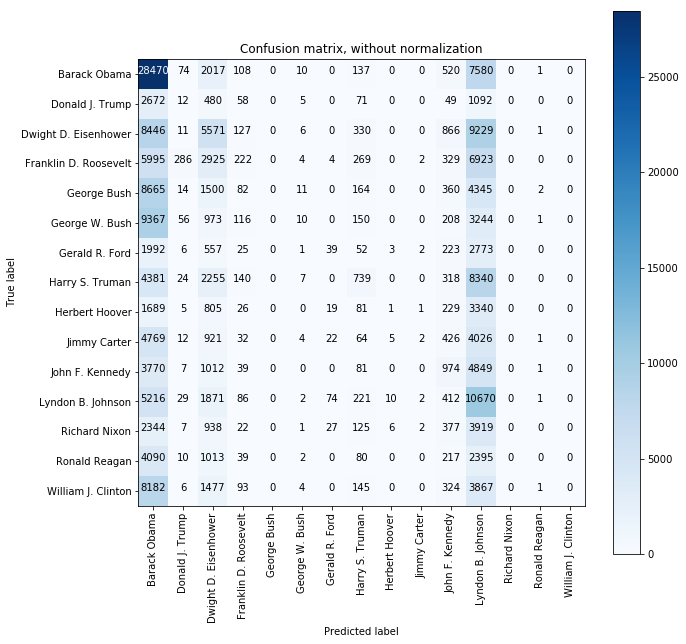

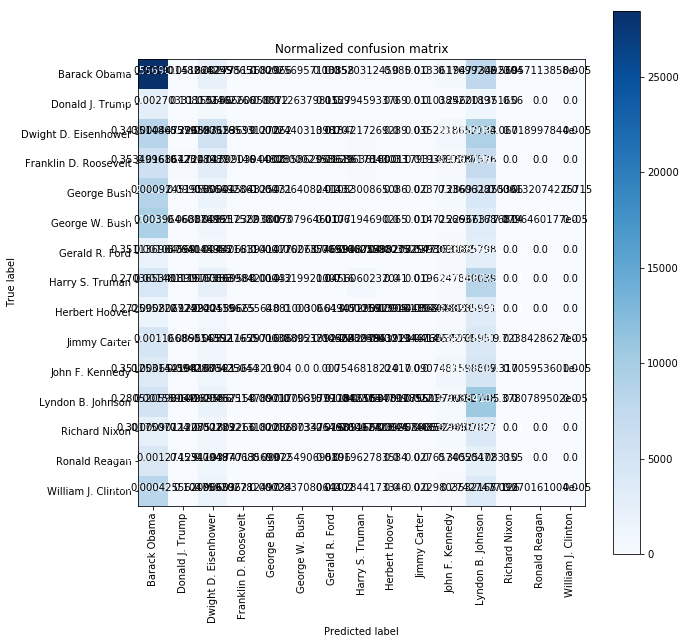

In [19]:
# Plot confusion matrix
#   from scikit-learn examples @
#   http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(np.sum(cm,axis=0))

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=(sorted(labels, key=labels.get)),
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(np.round(cnf_matrix,2), classes=(sorted(labels, key=labels.get)), normalize=True,
                      title='Normalized confusion matrix')

plt.show()